# COGS118B 2022FA
##### Group members:
#### Alexander Huynh, Andrina / Xiaoxuan Zhang, Nicolas Schaefer, Victorionna Tran

# Background

# Data

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
import tensorflow as tf
import keras

2022-12-05 05:59:33.890438: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-05 05:59:33.890481: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.wrappers.scikit_learn import KerasClassifier

### Importing data

In [42]:
df = pd.read_csv('cleanLargerEqDataset.csv')

In [43]:
timestamp_list = []
for d, t in zip(df['Date'], df['Time']):
    timestamp = datetime.datetime.strptime(d+' '+t, '%Y-%m-%d %H:%M:%S')
    timestamp_list.append(time.mktime(timestamp.timetuple()))
    
timeStamp = pd.Series(timestamp_list)
df['Timestamp'] = timeStamp.values
clean_df = df.drop(['Date', 'Time'], axis=1)

clean_df = clean_df.rename(columns={'Lat': 'Latitude', 'Lon': 'Longitude', 'Mag': 'Magnitude'})
clean_df

,Latitude,Longitude,Depth,Magnitude,Region,Timestamp
0,38.7748,-122.7645,0.2,0.4,"1km WSW of The Geysers, CA",1.670107e+09
1,34.5200,-118.9598,10.7,1.8,"14km NNW of Fillmore, CA",1.670106e+09
2,62.9029,-150.9087,89.0,1.1,"45 km N of Petersville, Alaska",1.670106e+09
3,33.8388,-116.7710,16.2,1.5,"9km S of Cabazon, CA",1.670105e+09
4,65.1832,-145.3003,6.0,1.6,"49 km SSW of Central, Alaska",1.670105e+09
...,...,...,...,...,...,...
4995,59.9210,-153.1838,111.2,1.9,"53 km ENE of Pedro Bay, Alaska",1.668694e+09
4996,33.2170,-116.7482,11.2,0.7,"3km SSE of Lake Henshaw, CA",1.668694e+09
4997,26.9701,55.2311,10.0,5.2,"57 km NE of Bandar-e Lengeh, Iran",1.668694e+09
4998,36.5818,-121.1080,10.8,1.0,"6km NNE of Pinnacles, CA",1.668693e+09


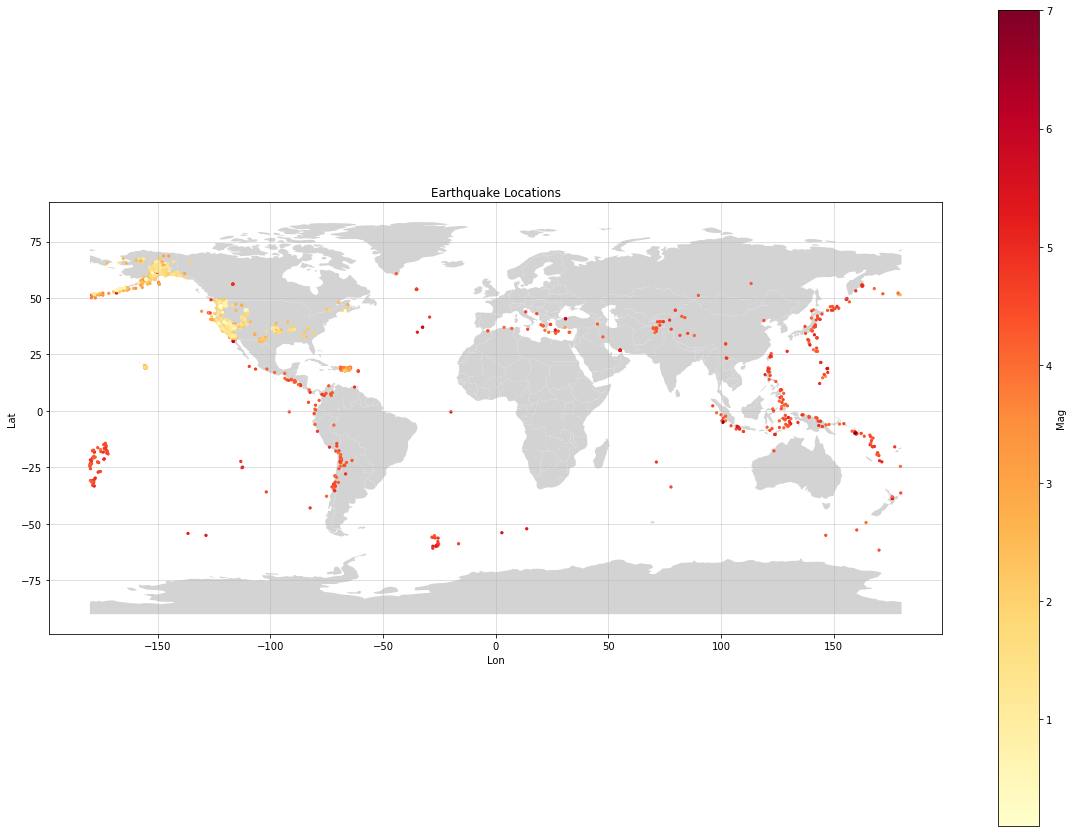

In [44]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# initialize an axis
fig, ax = plt.subplots(figsize=(20,15))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

# plot points
df.plot(x="Lon", y="Lat", marker ='.', kind="scatter", c="Mag", colormap="YlOrRd", 
        title="Earthquake Locations", ax=ax)

# add grid
ax.grid(visible=True, alpha=0.5)

plt.show()

In [45]:
X = clean_df[['Timestamp', 'Latitude', 'Longitude']]
y = clean_df[['Magnitude', 'Depth']]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 


(4000, 3) (1000, 3) (4000, 2) (1000, 2)


# Implementing Neural Network

#### Model-1
### LeNet-5 Benchmark 

Our benchmark CNN model is the LeNet-5 made by LeCun *et al* [<sup>[4]</sup>](#lenote). In the paper it was made to classify distinct hand-written digits in the MINST dataset. It is one of the classical CNN and it would be the benchmark model for comparing a hyper-tuned version of it and a residual neural network.

In [50]:
def LeNet(drop_1 = 0.25, drop_2 = 0.25, drop_3 = .5 , k_size1 = (3,3), k_size2 = (2,2)):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=k_size1, activation='relu')) 
    model.add(Conv2D(filters=32, kernel_size=k_size1, activation='relu')) 
    model.add(MaxPool2D(pool_size=(2,2))) 
    model.add(Dropout(rate=drop_1)) 
    model.add(Conv2D(filters=64, kernel_size=k_size2, activation='relu')) 
    model.add(Conv2D(filters=64, kernel_size=k_size2, activation='relu')) 
    model.add(MaxPool2D(pool_size=(2,2))) 
    model.add(Dropout(rate=drop_2)) 
    model.add(Flatten()) 
    model.add(Dense(256, activation='relu')) 
    model.add(Dropout(rate=drop_3))
    model.add(Dense(256, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    return model

#### Model-2
### CNN

In [51]:
def CNN(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

# Results

We will be employing a Kaggle data collection as a training set, which will include road signs from Germany with about 180 class labels.The training set will have around 100K photos, whereas the testing set will contain approximately 50K images.Three different sizes of Convolutional Neural Networks (CNNs) with and without Residual Connections will be tested for efficacy and performance. We trained a Convolutional Neural Network called LeNet. LeNet was used to classify the traffic signs that were included in the dataset. With the base model done, we ran hyperparameters tuning on four specified hyperparameters and executed a random hyperparameter search on the model. 



For our base model we decided on the LeNet neural network. We set the batch size to be 128 and the epoch to 40. The larger batch allowed us to increase the speed of the runtime of the process. By deploying only the 5x5 convolution filters we were able to get a 97.45% on the validation accuracy and a 95.55% on the training accuracy. With this newfound information we decided to tune these four specific hyperparameters. The batch size, dropout, filter size, and the epoch. Lastly, as mentioned above, we went with a five fold cross validation. 

In [52]:
test = LeNet()
test_plot = test.fit(X_train, y_train, batch_size= 10, epochs= 40, validation_data=(X_test,y_test))

Epoch 1/40


ValueError: in user code:

    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_111" (type Sequential).
    
    Input 0 of layer "conv2d_114" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (10, 3)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(10, 3), dtype=float64)
      • training=True
      • mask=None


In [53]:
# model = KerasClassifier(build_fn=CNN, verbose=0)

# neurons = [16, 32, 64, 128]
# batch_size = [10, 50, 100, 200]
# epochs = [40]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
# # activation = ['relu', 'sigmoid']
# # I also tried 'linear' and 'exponential'
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# # optimizer = ['SGD', 'Adadelta']
# # I also tried the other optimizers, 
# loss = ['categorical_crossentropy', 'poisson', 'kl_divergence', 'squared_hinge']

# param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

In [54]:
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
# grid_result = grid.fit(X_train, y_train)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [62]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(3,)))
model.add(Dense(32, activation='relu'))
#model.add(Dense(16, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='RMSprop', loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=10, epochs=40, verbose=1, validation_data=(X_test, y_test))

[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Epoch 1/40
400/400 [==============================] - 2s 3ms/step - loss: 0.5238 - accuracy: 0.1268 - val_loss: 0.5226 - val_accuracy: 0.1190
Epoch 2/40
400/400 [==============================] - 1s 2ms/step - loss: 0.5238 - accuracy: 0.1268 - val_loss: 0.5226 - val_accuracy: 0.1190
Epoch 3/40
400/400 [==============================] - 1s 3ms/step - loss: 0.5238 - accuracy: 0.1268 - val_loss: 0.5226 - val_accuracy: 0.1190
Epoch 4/40
400/400 [==============================] - 1s 2ms/step - loss: 0.5238 - accuracy: 0.1268 - val_loss: 0.5226 - val_accuracy: 0.1190
Epoch 5/40
400/400 [==============================] - 1s 3ms/step - loss: 0.5238 - accuracy: 0.1268 - val_loss: 0.5226 - val_accuracy: 0.1190
Epoch 6/40
400/400 [==============================] - 1s 3ms/step - loss: 0.5238 - accuracy: 0.1268 - val_loss: 0.5226 - val_accuracy: 0.1190
Epoch 7/40
400/400 [==============================] - 1s 3ms/step - loss: 0.5238 - accuracy: 0.1268 - val_loss: 0.5226 - val_accuracy: 0.1190
Epoch 

In [64]:
test = CNN(32, 'relu', 'SGD', 'squared_hinge')
test_plot = test.fit(X_train, y_train, batch_size= 128, epochs= 40, validation_data=(X_test,y_test))

Epoch 1/40
32/32 [==============================] - 1s 9ms/step - loss: 0.7843 - accuracy: 0.8733 - val_loss: 0.8226 - val_accuracy: 0.8810
Epoch 2/40
32/32 [==============================] - 0s 5ms/step - loss: 0.7843 - accuracy: 0.8733 - val_loss: 0.8226 - val_accuracy: 0.8810
Epoch 3/40
32/32 [==============================] - 0s 5ms/step - loss: 0.7843 - accuracy: 0.8733 - val_loss: 0.8226 - val_accuracy: 0.8810
Epoch 4/40
32/32 [==============================] - 0s 5ms/step - loss: 0.7843 - accuracy: 0.8733 - val_loss: 0.8226 - val_accuracy: 0.8810
Epoch 5/40
32/32 [==============================] - 0s 4ms/step - loss: 0.7843 - accuracy: 0.8733 - val_loss: 0.8226 - val_accuracy: 0.8810
Epoch 6/40
32/32 [==============================] - 0s 4ms/step - loss: 0.7843 - accuracy: 0.8733 - val_loss: 0.8226 - val_accuracy: 0.8810
Epoch 7/40
32/32 [==============================] - 0s 5ms/step - loss: 0.7843 - accuracy: 0.8733 - val_loss: 0.8226 - val_accuracy: 0.8810
Epoch 8/40
32/32 [==

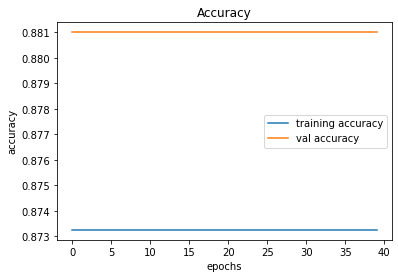

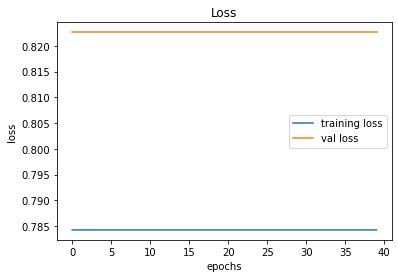

In [65]:
plt.figure(0)
plt.plot(test_plot.history['accuracy'], label='training accuracy')
plt.plot(test_plot.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(test_plot.history['loss'], label='training loss')
plt.plot(test_plot.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In the graphs we can see as the model is going through more epochs the training and validation are imporoving. We can also see a convergence of the accuracies in the later stages. We see that the loss is getting smaller and converging.

### Lenet Hyperparameter Tuning

Now we have seen the benchmark model in action, we will now try hyper parameter tunning to see if we can fine tune the model for better accuracy.

In [66]:
batches = [32,64,128]
dropout = [0.2, 0.25, 0.5, 0.1] 
filtersize_1 = [(5,5), (7,7), (9,9)]
filtersize_2 = [(3,3), (2,2), (1,1)]
search_space = dict(batch_size = batches, drop_1 = dropout, drop_2 = dropout, drop_3 = dropout, k_size1 = filtersize_1, k_size2 = filtersize_2)

These will be the hyperparameters that we are going to tune our LeNet Neural network: 
- Batches is the batch size of the data, it is the amount data points in a single partition that is going to be passed through our Neural Network, the higher the value the faster it runs. 
- Dropout is the dropout rate of the data, it is primarily used to compensate for overfitting, we are going to use 3 dropout rates for hypertuning. 
- Filter size is the size of our filter for the neural network, in this case we have to run a smaller filter on the latter half of our NN. 
- Epoch is the number of times we are going to train our neural network. It will always tune in hyperparameter tuning, but 40 epochs would be a solid number.

As stated above we decided to tune these four specific hyperparameters: batch size, drop out rate, filter size and epoch. While smaller batch sizes generally give a better result, we did not want to suffer the consequence of a high computation cost. Therefore, we choose these three batch sizes to run with, 32, 64 and 128. The dropout rate allows for better accuracy because it can help with overfitting. For this hyperparameter we chose: 0.2,0.25,0.5, and 0.1. The convolution filters we chose were 5x5, 7x7 and 9x9. Lastly, we decided it was best to leave the epoch size to 40. This is because any larger size would greatly increase the runtime and computation load. 

In [67]:
clf_keras = KerasClassifier(build_fn = LeNet, epochs = 40, verbose = 0)

/tmp/ipykernel_178182/2484242110.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf_keras = KerasClassifier(build_fn = LeNet, epochs = 40, verbose = 0)


We will wrap our tensorflow function into a Scikit learn wrapper in order to do our cross validation and randomized search.

In [68]:
rand = RandomizedSearchCV(estimator=clf_keras, param_distributions=search_space, verbose= 3, cv = 5)

This cross validation will be a randomized search CV, since it will take a lot of computation and time to perform a grid search on the every possible combination of hyperparameters that we have in our dictionary. Utilizing randomized search CV as the cross validation, will allow us to perform a search on all the hyperparameter combinations to find the best ones while still remaining efficient. With five cross validation folds and ten candidates, we will end with fifty runs for our cross validation. 

In [69]:
rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END batch_size=32, drop_1=0.5, drop_2=0.25, drop_3=0.2, k_size1=(5, 5), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 2/5] END batch_size=32, drop_1=0.5, drop_2=0.25, drop_3=0.2, k_size1=(5, 5), k_size2=(3, 3);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 3/5] END batch_size=32, drop_1=0.5, drop_2=0.25, drop_3=0.2, k_size1=(5, 5), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 4/5] END batch_size=32, drop_1=0.5, drop_2=0.25, drop_3=0.2, k_size1=(5, 5), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 5/5] END batch_size=32, drop_1=0.5, drop_2=0.25, drop_3=0.2, k_size1=(5, 5), k_size2=(3, 3);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 1/5] END batch_size=32, drop_1=0.1, drop_2=0.25, drop_3=0.1, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 2/5] END batch_size=32, drop_1=0.1, drop_2=0.25, drop_3=0.1, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 3/5] END batch_size=32, drop_1=0.1, drop_2=0.25, drop_3=0.1, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 4/5] END batch_size=32, drop_1=0.1, drop_2=0.25, drop_3=0.1, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 5/5] END batch_size=32, drop_1=0.1, drop_2=0.25, drop_3=0.1, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 1/5] END batch_size=64, drop_1=0.5, drop_2=0.1, drop_3=0.25, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 2/5] END batch_size=64, drop_1=0.5, drop_2=0.1, drop_3=0.25, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 3/5] END batch_size=64, drop_1=0.5, drop_2=0.1, drop_3=0.25, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 4/5] END batch_size=64, drop_1=0.5, drop_2=0.1, drop_3=0.25, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 5/5] END batch_size=64, drop_1=0.5, drop_2=0.1, drop_3=0.25, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 1/5] END batch_size=128, drop_1=0.1, drop_2=0.25, drop_3=0.25, k_size1=(9, 9), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 2/5] END batch_size=128, drop_1=0.1, drop_2=0.25, drop_3=0.25, k_size1=(9, 9), k_size2=(3, 3);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 3/5] END batch_size=128, drop_1=0.1, drop_2=0.25, drop_3=0.25, k_size1=(9, 9), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 4/5] END batch_size=128, drop_1=0.1, drop_2=0.25, drop_3=0.25, k_size1=(9, 9), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 5/5] END batch_size=128, drop_1=0.1, drop_2=0.25, drop_3=0.25, k_size1=(9, 9), k_size2=(3, 3);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 1/5] END batch_size=64, drop_1=0.5, drop_2=0.5, drop_3=0.1, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 2/5] END batch_size=64, drop_1=0.5, drop_2=0.5, drop_3=0.1, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 3/5] END batch_size=64, drop_1=0.5, drop_2=0.5, drop_3=0.1, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 4/5] END batch_size=64, drop_1=0.5, drop_2=0.5, drop_3=0.1, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 5/5] END batch_size=64, drop_1=0.5, drop_2=0.5, drop_3=0.1, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 1/5] END batch_size=64, drop_1=0.25, drop_2=0.1, drop_3=0.2, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 2/5] END batch_size=64, drop_1=0.25, drop_2=0.1, drop_3=0.2, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 3/5] END batch_size=64, drop_1=0.25, drop_2=0.1, drop_3=0.2, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 4/5] END batch_size=64, drop_1=0.25, drop_2=0.1, drop_3=0.2, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 5/5] END batch_size=64, drop_1=0.25, drop_2=0.1, drop_3=0.2, k_size1=(5, 5), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 1/5] END batch_size=64, drop_1=0.5, drop_2=0.2, drop_3=0.5, k_size1=(5, 5), k_size2=(1, 1);, score=nan total time=   0.1s
[CV 2/5] END batch_size=64, drop_1=0.5, drop_2=0.2, drop_3=0.5, k_size1=(5, 5), k_size2=(1, 1);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 3/5] END batch_size=64, drop_1=0.5, drop_2=0.2, drop_3=0.5, k_size1=(5, 5), k_size2=(1, 1);, score=nan total time=   0.1s
[CV 4/5] END batch_size=64, drop_1=0.5, drop_2=0.2, drop_3=0.5, k_size1=(5, 5), k_size2=(1, 1);, score=nan total time=   0.1s
[CV 5/5] END batch_size=64, drop_1=0.5, drop_2=0.2, drop_3=0.5, k_size1=(5, 5), k_size2=(1, 1);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 1/5] END batch_size=32, drop_1=0.25, drop_2=0.1, drop_3=0.5, k_size1=(7, 7), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 2/5] END batch_size=32, drop_1=0.25, drop_2=0.1, drop_3=0.5, k_size1=(7, 7), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 3/5] END batch_size=32, drop_1=0.25, drop_2=0.1, drop_3=0.5, k_size1=(7, 7), k_size2=(2, 2);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 4/5] END batch_size=32, drop_1=0.25, drop_2=0.1, drop_3=0.5, k_size1=(7, 7), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 5/5] END batch_size=32, drop_1=0.25, drop_2=0.1, drop_3=0.5, k_size1=(7, 7), k_size2=(2, 2);, score=nan total time=   0.1s
[CV 1/5] END batch_size=32, drop_1=0.25, drop_2=0.2, drop_3=0.25, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 2/5] END batch_size=32, drop_1=0.25, drop_2=0.2, drop_3=0.25, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 3/5] END batch_size=32, drop_1=0.25, drop_2=0.2, drop_3=0.25, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 4/5] END batch_size=32, drop_1=0.25, drop_2=0.2, drop_3=0.25, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 5/5] END batch_size=32, drop_1=0.25, drop_2=0.2, drop_3=0.25, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 1/5] END batch_size=64, drop_1=0.2, drop_2=0.1, drop_3=0.25, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 2/5] END batch_size=64, drop_1=0.2, drop_2=0.1, drop_3=0.25, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

[CV 3/5] END batch_size=64, drop_1=0.2, drop_2=0.1, drop_3=0.25, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 4/5] END batch_size=64, drop_1=0.2, drop_2=0.1, drop_3=0.25, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s
[CV 5/5] END batch_size=64, drop_1=0.2, drop_2=0.1, drop_3=0.25, k_size1=(7, 7), k_size2=(3, 3);, score=nan total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/xiz031/.local/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", li

ValueError: in user code:

    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_218" (type Sequential).
    
    Input 0 of layer "conv2d_522" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (32, 3)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(32, 3), dtype=float64)
      • training=True
      • mask=None


After tuning the fitting of our randomized search, we came up with the best score below.

In [70]:
rand.best_score_

nan

These are the parameters that resulted in the best score:

In [71]:
params = rand.best_params_
params

{'k_size2': (3, 3),
 'k_size1': (5, 5),
 'drop_3': 0.2,
 'drop_2': 0.25,
 'drop_1': 0.5,
 'batch_size': 32}

This will be our hyperparameter tuned CNN model. Some parameters are the same like the 2nd dropout rate the first filtersize. We have a smaller begining dropout rate and have a smaller size 2nd filter.

In [72]:
hyper = LeNet(drop_1= 0.5, drop_2= 0.25, drop_3 = 0.2, k_size1= (5,5), k_size2=(3,3))
hyper_plot = hyper.fit(X_train, y_train, batch_size= 64, epochs= 40, validation_data=(X_test,y_test))

Epoch 1/40


ValueError: in user code:

    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/xiz031/.local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_219" (type Sequential).
    
    Input 0 of layer "conv2d_526" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 3)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 3), dtype=float64)
      • training=True
      • mask=None


In [73]:
plt.plot(hyper_plot.history['accuracy'], label='training accuracy')
plt.plot(hyper_plot.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

NameError: name 'hyper_plot' is not defined

From the graph and the verbose of fitting the data into our model, it looks like our hyperparameter tuned model is overfitting to the training data. We can see the intersect of the two accuracy values within our graph. Our training accuracy is higher then the validation acuracy. It is still an accurate model none the less, with a 97.13% validation accuracy. We can try implementing our model with less epochs in order to combat the overfitting of training data.

Compared to the base model our hyperparameter tuned model, the hyper-tuned model overfitted with the training data set. The validation accuracy of the base model is 97.745% with a training accuracy of 95.55%, while the hyper tuned model has a validation accuracy of 97.1% with a 98% training accuracy. Overall the base LeNet-5 model would be the best performer out of the two models. We could have done a grid search, to find the best true hyperparameters, but that would be computationally expensive.

Having the the model that is overfitted to the training data is still normal. We will still use the hyper-parameters that we have came up. Since, the hyper-tuned model has a decent validation accuracy.

### LeNet-5 Architecture

# Team Contributions
- Alexander Huynh: Researching models, Creating model, Write-up, Video presentation
- Andrina / Xiaoxuan Zhang: Finding dataset, Model implementation & testing, Video presentation
- Nicolas Schaefer: Data collecting & cleaning, Webscraping, Video presentation
- Victorionna Tran: Data cleaning & wrangling, Data visualization, Video presentation

# Footnotes
<a name="arcosnote"></a>1.[^](#arcosnote): Evaluation of deep neural networks for traffic sign detection systems. *Neurocomputing 2018*. https://paperswithcode.com/paper/evaluation-of-deep-neural-networks-for<br> 
<a name="kakarlanote"></a>2.[^](#kakarlanote): Traffic Sign Classification using Residual Networks(ResNet). *Syam Kakarla*. https://towardsdatascience.com/traffic-sign-classification-using-residual-networks-resnet-4b550046ff83<br>
<a name="pytorchnote"></a>3.[^](#pytorchnote): How Does PyTorch Support ResNet?. *run.ai*. https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-resnet#ResNet-Architecture<br>
<a name= "lenote"></a>4.[^](#lenote): Gradient-Base Learning applied to Document Recognition. *Yann LeCun et. al*. http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf